# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
#from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import time
#import gc

#google service
from google.cloud import bigquery

# GCP Connection

In [2]:
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'project_id' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

### Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=playground-216119:US:bquxjob_3fbfd69a_186df7e2743)
back to BigQuery to edit the query within the BigQuery user interface.

In [ ]:
# Running this code will display the query used to generate your previous job

job = client.get_job('job_id') # Job ID inserted based on the query results selected to explore
print(job.query)

### Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [ ]:
# Running this code will read results from your previous job

job = client.get_job('job_id') # Job ID inserted based on the query results selected to explore
df = job.to_dataframe()
df

## sql query on jupyter

### Helper Function

In [34]:

def gcp2df(sql, client):

        t1 = time.time()
        q=client.query(sql)
        results=q.result()
        t2 = time.time()
        print("results type :", type(results))
        print("downloading time:", t2-t1)

        results=results.to_dataframe()
        t3 = time.time()

        print("df-ing time:", t3-t2)
        print("total time:", t3-t1)
        return results


### connection

In [4]:
project= 'project_id'
dataset='table_id'
client=bigquery.Client(project=project)
dataset_ref=client.dataset(dataset)

table_id = project + '.' + dataset


### SQL query

In [35]:
query = """
       query
  """.format(table=table_id)

df=gcp2df(query, client)

results type : <class 'google.cloud.bigquery.table.RowIterator'>
downloading time: 0.9385056495666504
df-ing time: 0.9662420749664307
total time: 1.904747724533081


# details about columns


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   product           100000 non-null  object 
 1   timestamp         100000 non-null  dbdate 
 2   sales             100000 non-null  Int64  
 3   normalized_sales  100000 non-null  float64
 4   sales_change      92095 non-null   float64
dtypes: Int64(1), dbdate(1), float64(2), object(1)
memory usage: 3.9+ MB


# converting types

### before

In [11]:
df.isnull().sum()

product                0
timestamp              0
sales                  0
normalized_sales       0
sales_change        7905
dtype: int64

In [12]:
df.dtypes

product              object
timestamp            dbdate
sales                 Int64
normalized_sales    float64
sales_change        float64
dtype: object

In [13]:
df['sales'] = df['sales'].astype(int)
df['normalized_sales'] = df['normalized_sales'].astype(int)
df['sales_change'] = df['sales_change'].fillna(0).astype(int)

### after

In [14]:
df.dtypes

product             object
timestamp           dbdate
sales                int64
normalized_sales     int64
sales_change         int64
dtype: object

In [15]:
df.isnull().sum()

product             0
timestamp           0
sales               0
normalized_sales    0
sales_change        0
dtype: int64

# analysing 'sales'

## descriptive statistics summary
* if you don't understand the numbers in the .describe() functions there are bunch of statistical analysis related this in the next sections.

In [16]:
df['sales'].describe()

count    100000.00000
mean         25.69154
std          39.76882
min           4.00000
25%           6.00000
50%          11.00000
75%          28.00000
max        1824.00000
Name: sales, dtype: float64

In [17]:
df['normalized_sales'].describe()

count    100000.000000
mean         46.479280
std          28.386738
min           1.000000
25%          23.000000
50%          42.000000
75%          67.000000
max         100.000000
Name: normalized_sales, dtype: float64

In [18]:
df['sales_change'].describe()

count    100000.000000
mean         -0.456340
std          24.416213
min         -99.000000
25%         -11.000000
50%           0.000000
75%           9.000000
max          99.000000
Name: sales_change, dtype: float64

### Check Normality in sales (sales & normalized_sales & sales_change)

* Normality refers to a specific statistical distribution called a normal distribution, or sometimes the Gaussian distribution or bell-shaped curve. The normal distribution is a symmetrical continuous distribution defined by the mean and standard deviation of the data.

* We can check these for finding normality
>> **SKEWNESS, KURTOSIS and HISTOGRAM**


* **Skewness**

skewness is a degree of asymmetry observed in a probability distribution that deviates from the symmetrical normal distribution (bell curve) in a given set of data.

A skewed data set, typical values fall between the first quartile (Q1) and the third quartile (Q3).

The normal distribution helps to know a skewness. When we talk about normal distribution, data symmetrically distributed. The symmetrical distribution has zero skewness as all measures of a central tendency lies in the middle.

> The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero.

> Negative values for the skewness indicate data that are skewed left and positive values for the skewness indicate data that are skewed right.


![](https://i.ibb.co/y48vQHR/96971skw1.png)

When data is symmetrically distributed, the left-hand side, and right-hand side, contain the same number of observations. (If the dataset has 90 values, then the left-hand side has 45 observations, and the right-hand side has 45 observations.). But, what if not symmetrical distributed? That data is called asymmetrical data, and that time skewness
comes into the picture.



* **Kurtosis**

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.

> That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.



* The histogram is an effective graphical technique for showing both the skewness and kurtosis of data set.

* **Histogram**

A histogram is a graphical representation of a grouped frequency distribution with continuous classes. It is an area diagram and can be defined as a set of rectangles with bases along with the intervals between class boundaries and with areas proportional to frequencies in the corresponding classes.

* A histogram is used to check the shape of the data distribution.
* Used to check whether the process changes from one period to another.
* Used to determine whether the output is different when it involves two or more processes.

#### sales

##### skewness & kurtosis

In [19]:
print("Skewness: %f" % df['sales'].skew())
print("Kurtosis: %f" % df['sales'].kurt())

Skewness: 7.550231
Kurtosis: 169.555257


**Positive Skewed or Right-Skewed  (Positive Skewness)**
>>In statistics, a positively skewed or right-skewed distribution has a long right tail. It is a sort of distribution where the measures are dispersing, unlike symmetrically distributed data where all measures of the central tendency (mean, median, and mode) equal each other. This makes Positively Skewed Distribution a type of distribution where the mean, median, and mode of the distribution are positive rather than negative or zero.

![](https://i.ibb.co/LRHmSh4/64710new-positive.png)

**Leptokurtic (Kurtosis > 3)**
>>Leptokurtic has very long and skinny tails, which means there are more chances of outliers. Positive values of kurtosis indicate that distribution is peaked and possesses thick tails. An extremely positive kurtosis indicates a distribution where more numbers are located in the tails of the distribution instead of around the mean

##### histogram & probability plot

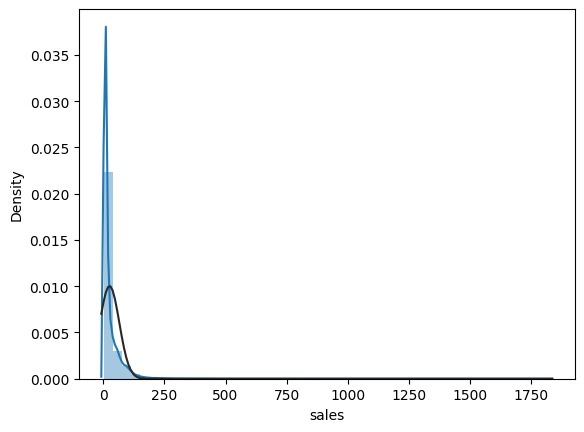

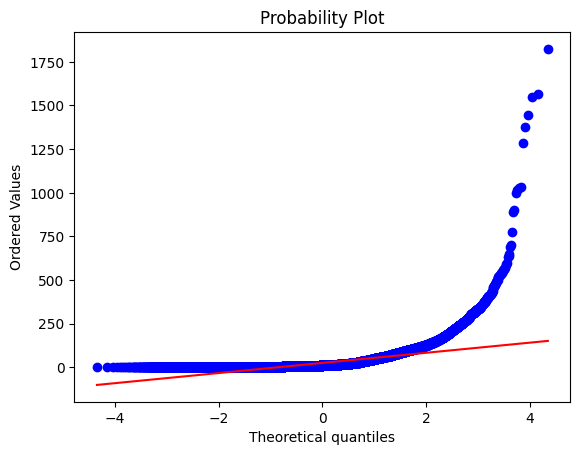

In [20]:
sns.distplot(df['sales'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['sales'], plot=plt)

* <b>Normal probability plot</b> - Data distribution should closely follow the diagonal that represents the normal distribution.
* <b>Histogram</b> - Refeers to Kurtosis and skewness.

#### normalized_sales

##### skewness and kurtosis

In [21]:
print("Skewness: %f" % df['normalized_sales'].skew())
print("Kurtosis: %f" % df['normalized_sales'].kurt())

Skewness: 0.433533
Kurtosis: -0.873967


* If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.

>> Negative Skewed or Left-Skewed (Negative Skewness)
A negatively skewed or left-skewed distribution has a long left tail; it is the complete opposite of a positively skewed distribution. In statistics, negatively skewed distribution refers to the distribution model where more values are plots on the right side of the graph, and the tail of the distribution is spreading on the left side.
>>In negatively skewed, the mean of the data is less than the median (a large number of data-pushed on the left-hand side). Negatively Skewed Distribution is a type of distribution where the mean, median, and mode of the distribution are negative rather than positive or zero.


* Platykurtic (Kurtosis < 3)
>> Platykurtic having a lower tail and stretched around center tails means most data points are present in high proximity to the mean. A platykurtic distribution is flatter (less peaked) when compared with the normal distribution.

##### histogram & probability plot

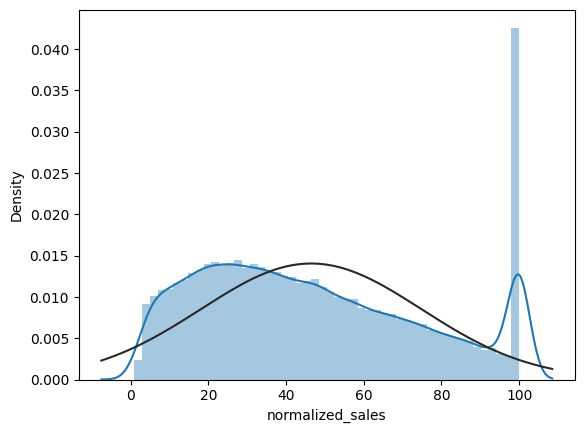

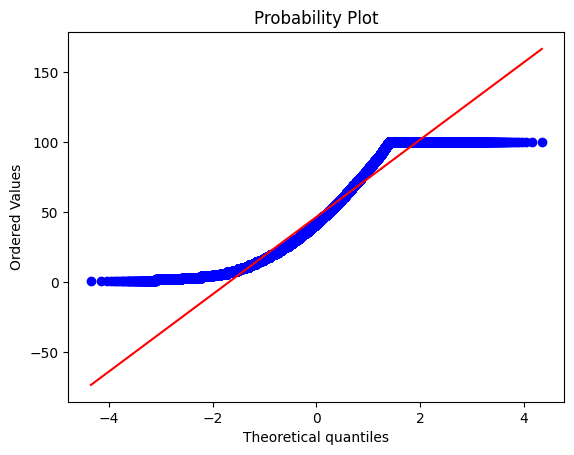

In [22]:
sns.distplot(df['normalized_sales'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['normalized_sales'], plot=plt)

#### sales_change

##### skewness and kurtosis

In [23]:
#skewness and kurtosis
print("Skewness: %f" % df['sales_change'].skew())
print("Kurtosis: %f" % df['sales_change'].kurt())

Skewness: -0.088948
Kurtosis: 2.479847


If the skewness is between -1 & -0.5 (negative skewed) or between **0.5 & 1(positive skewed)**, the data are slightly skewed.


**Platykurtic (Kurtosis < 3)**
>>Platykurtic having a lower tail and stretched around center tails means most data points are present in high proximity to the mean. A platykurtic distribution is flatter (less peaked) when compared with the normal distribution.

##### histogram & probability plot

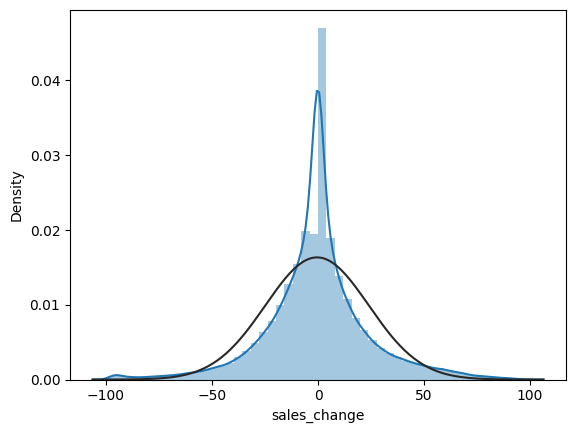

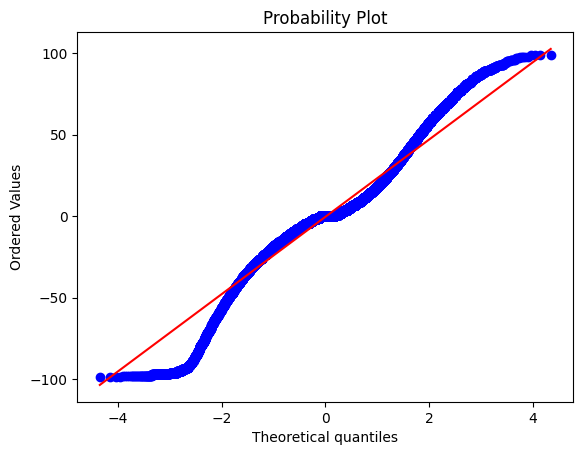

In [24]:
sns.distplot(df['sales_change'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['sales_change'], plot=plt)

## Homoscedasticity and Heteroscedasticity in sales

* Homoscedasticity refers to a situation where the variance of the errors (or residuals) of a regression model is constant across all levels of the predictor variable(s). This means that the spread of the data points around the regression line is consistent across the entire range of the predictor variable.

* Heteroscedasticity is a variance of the residuals that increases as the predictor variable increases. Notice how the spread of the residuals becomes wider as we move from left to right. This can be a problem because it violates the assumption of equal variance, which can lead to biased parameter estimates and inaccurate hypothesis tests.


>> Graphing is the best approach for testing  homoscedasticity or heteroscedasticity for two variables.

![Homoscedasticity and Heteroscedasticity](https://i.ibb.co/8X3Yskn/imgonline-com-ua-twotoone-p0h-Jzo-TNe-GDTT9.jpg)



### normalized_sales & sales

<Axes: xlabel='normalized_sales', ylabel='sales'>

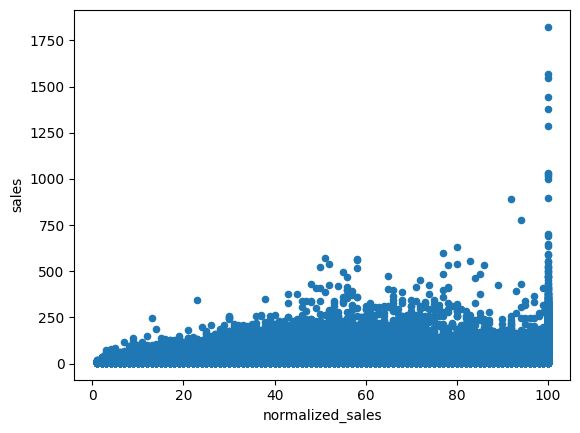

In [25]:
var = 'normalized_sales'
data = pd.concat([df['sales'], df[var]], axis=1)
data.plot.scatter(x=var, y='sales')

* It seems that 'sales' and 'normalized_sales' have not **strong** linear relation ship*


### sales_change & sales

<Axes: xlabel='sales_change', ylabel='sales'>

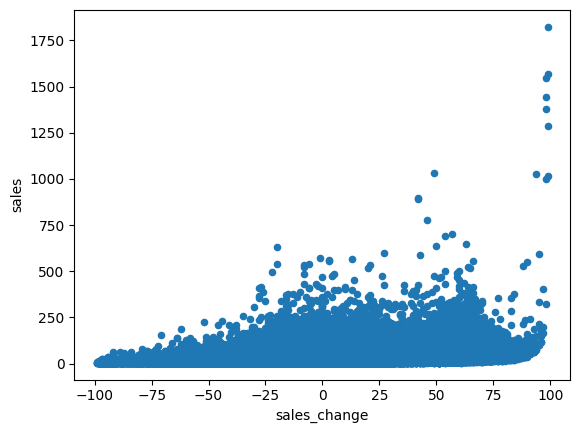

In [26]:
var = 'sales_change'
data = pd.concat([df['sales'], df[var]], axis=1)
data.plot.scatter(x=var, y='sales')

* It seems that there is no linear relation ship between sales and sales_change


### sales_change & normalized_sales

<Axes: xlabel='normalized_sales', ylabel='sales_change'>

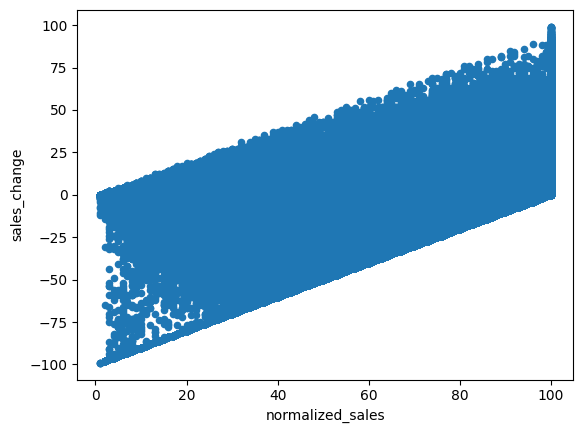

In [31]:
var = 'normalized_sales'
data = pd.concat([df['sales_change'], df[var]], axis=1)
data.plot.scatter(x=var, y='sales_change')

* It seems that 'sales_change' and 'normalized_sales' have **strong** linear relation ship

# Correlation Matrix

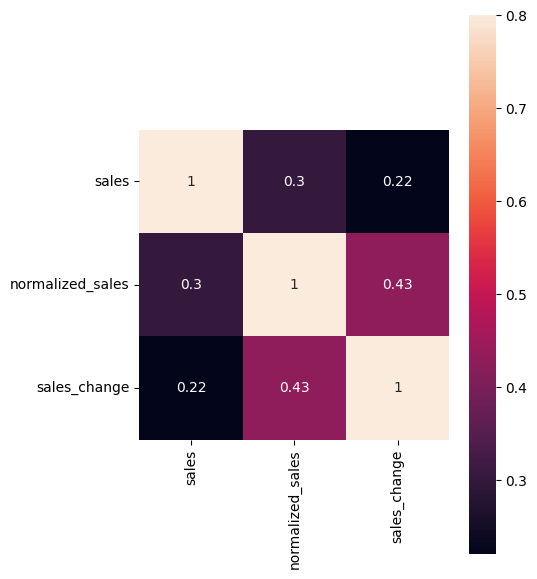

In [32]:
corrmat = df.corr()
plt.figure(figsize = (5,7))
sns.heatmap(corrmat,annot=True, vmax=.8, square=True);